In [2]:

# setting logging to print only error messages from Sklearnex
import logging
logging.basicConfig()
logging.getLogger("SKLEARNEX").setLevel(logging.ERROR)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from datetime import datetime

#import tensorflow as tf
import os

from sklearn.metrics import mean_squared_error,mean_absolute_error
import math

import warnings
warnings.filterwarnings("ignore")

sns.set_theme(palette="Set2")


def get_mda(y, yhat):
    """Mean Directional Accuracy, as per:
    https://www.wikiwand.com/en/Mean_Directional_Accuracy
    """
    a = np.sign(np.diff(y))
    b = np.sign(np.diff(yhat))
    return np.sum(a == b)/a.shape[0]

In [3]:
!pip install tensorflow


# Importing necessary libaries

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

# Read the data

In [5]:
df=pd.read_csv("GOOGLE  BP DATA.csv")

In [6]:
df.head()

,Date,Open,High,Low,Close,Volume,Day of the week,Change,NASDAQ
0,01-04-2014,27.859013,28.344681,27.859013,28.280355,158434.0,3.0,-0.007976,3658.399902
1,02-04-2014,29.917362,30.158699,28.032537,28.272379,2942055.0,4.0,0.136623,3665.989990
2,03-04-2014,28.414488,29.283602,28.129271,28.409002,101983228.0,5.0,-1.326357,3637.580078
3,04-04-2014,28.653831,28.809404,27.075665,27.082645,127386783.0,6.0,-0.248817,3539.379883
4,07-04-2014,26.962973,27.348913,26.285334,26.833828,88033033.0,2.0,0.835207,3507.750000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2267 entries, 0 to 2266
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             2205 non-null   object 
 1   Open             2205 non-null   float64
 2   High             2205 non-null   float64
 3   Low              2205 non-null   float64
 4   Close            2205 non-null   float64
 5   Volume           2205 non-null   float64
 6   Day of the week  2205 non-null   float64
 7   Change           2205 non-null   float64
 8   NASDAQ           2205 non-null   float64
dtypes: float64(8), object(1)
memory usage: 159.5+ KB


# Data Preprocessing

In [8]:
df["Date"] = pd.to_datetime(df["Date"])

In [9]:
df.set_index('Date',inplace=True)

In [10]:
df.head()

,Open,High,Low,Close,Volume,Day of the week,Change,NASDAQ
Date,,,,,,,,
2014-01-04,27.859013,28.344681,27.859013,28.280355,158434.0,3.0,-0.007976,3658.399902
2014-02-04,29.917362,30.158699,28.032537,28.272379,2942055.0,4.0,0.136623,3665.989990
2014-03-04,28.414488,29.283602,28.129271,28.409002,101983228.0,5.0,-1.326357,3637.580078
2014-04-04,28.653831,28.809404,27.075665,27.082645,127386783.0,6.0,-0.248817,3539.379883
2014-07-04,26.962973,27.348913,26.285334,26.833828,88033033.0,2.0,0.835207,3507.750000


# Missing entries


In [11]:
min(df.index)

Timestamp('2014-01-04 00:00:00')

In [12]:
max(df.index)

Timestamp('2022-12-30 00:00:00')

In [13]:
all_datetimes = pd.date_range(min(df.index), max(df.index), freq="D")
all_datetimes

DatetimeIndex(['2014-01-04', '2014-01-05', '2014-01-06', '2014-01-07',
               '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-11',
               '2014-01-12', '2014-01-13',
               ...
               '2022-12-21', '2022-12-22', '2022-12-23', '2022-12-24',
               '2022-12-25', '2022-12-26', '2022-12-27', '2022-12-28',
               '2022-12-29', '2022-12-30'],
              dtype='datetime64[ns]', length=3283, freq='D')

In [14]:
all_datetimes.shape

(3283,)

# Supplying missing values

## Insert missing datetimes

In [15]:
all_datetimes_df = pd.DataFrame(index=all_datetimes)
all_datetimes_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3283 entries, 2014-01-04 to 2022-12-30
Freq: D
Empty DataFrame

In [16]:
df = pd.merge(all_datetimes_df, df, how="left", left_index=True, right_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3283 entries, 2014-01-04 to 2022-12-30
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open             2205 non-null   float64
 1   High             2205 non-null   float64
 2   Low              2205 non-null   float64
 3   Close            2205 non-null   float64
 4   Volume           2205 non-null   float64
 5   Day of the week  2205 non-null   float64
 6   Change           2205 non-null   float64
 7   NASDAQ           2205 non-null   float64
dtypes: float64(8)
memory usage: 230.8 KB


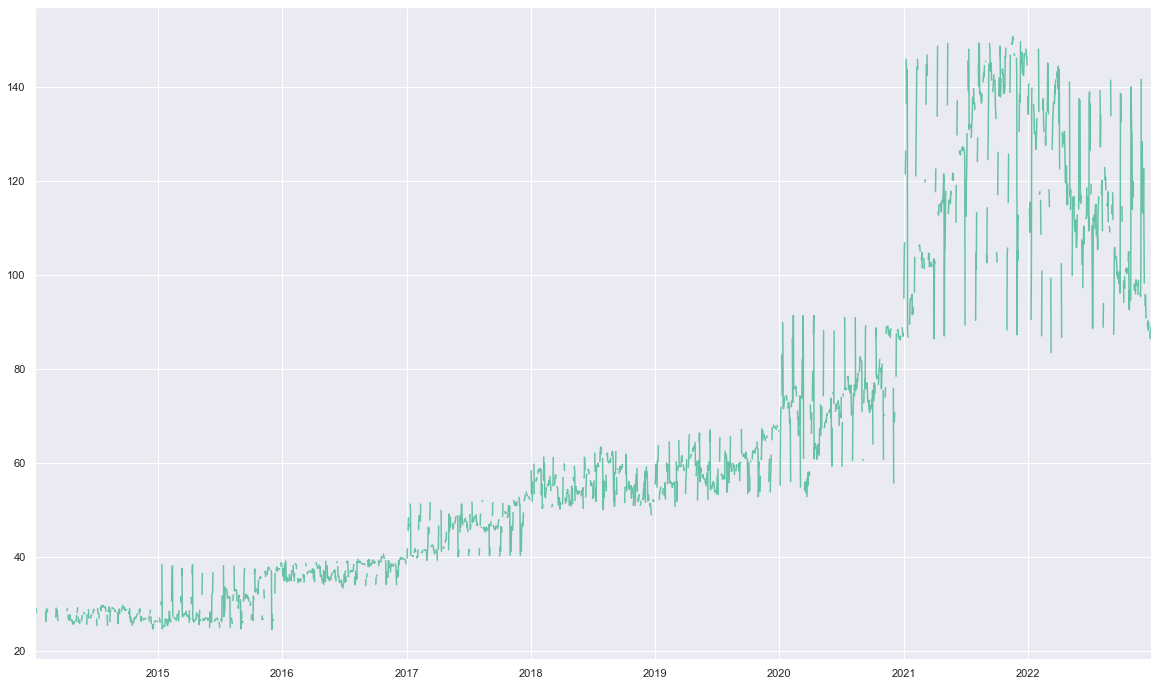

In [17]:
plot = df['Close'].plot(figsize=(20, 12))

In [18]:
df["Close"] = df["Close"].ffill()
df["NASDAQ"]=df["NASDAQ"].ffill()
df["Open"]=df["Open"].ffill()
df["High"]=df["High"].ffill()
df["Low"]=df["Low"].ffill()
df["Volume"]=df["Volume"].ffill()
df["Change"]=df["Change"].ffill()
df.head(12)

,Open,High,Low,Close,Volume,Day of the week,Change,NASDAQ
2014-01-04,27.859013,28.344681,27.859013,28.280355,158434.0,3.0,-0.007976,3658.399902
2014-01-05,26.283339,26.573542,26.122280,26.494759,38110345.0,5.0,-0.170533,3594.360107
2014-01-06,26.283339,26.573542,26.122280,26.494759,38110345.0,NaN,-0.170533,3594.360107
2014-01-07,28.836828,29.139996,28.753557,29.053734,28959290.0,3.0,-0.016705,3894.330078
2014-01-08,28.441914,28.719152,28.065447,28.226006,39105069.0,6.0,0.353031,3879.669922
2014-01-09,28.441914,28.719152,28.065447,28.226006,39105069.0,NaN,0.353031,3879.669922
2014-01-10,28.721645,28.799931,28.272877,28.335705,28909153.0,4.0,0.090252,3984.739990
2014-01-11,28.721645,28.799931,28.272877,28.335705,28909153.0,NaN,0.090252,3984.739990
2014-01-12,26.871225,26.996382,26.520189,26.616922,42307838.0,2.0,-0.002493,4287.810059
2014-01-13,26.871225,26.996382,26.520189,26.616922,42307838.0,NaN,-0.002493,4287.810059


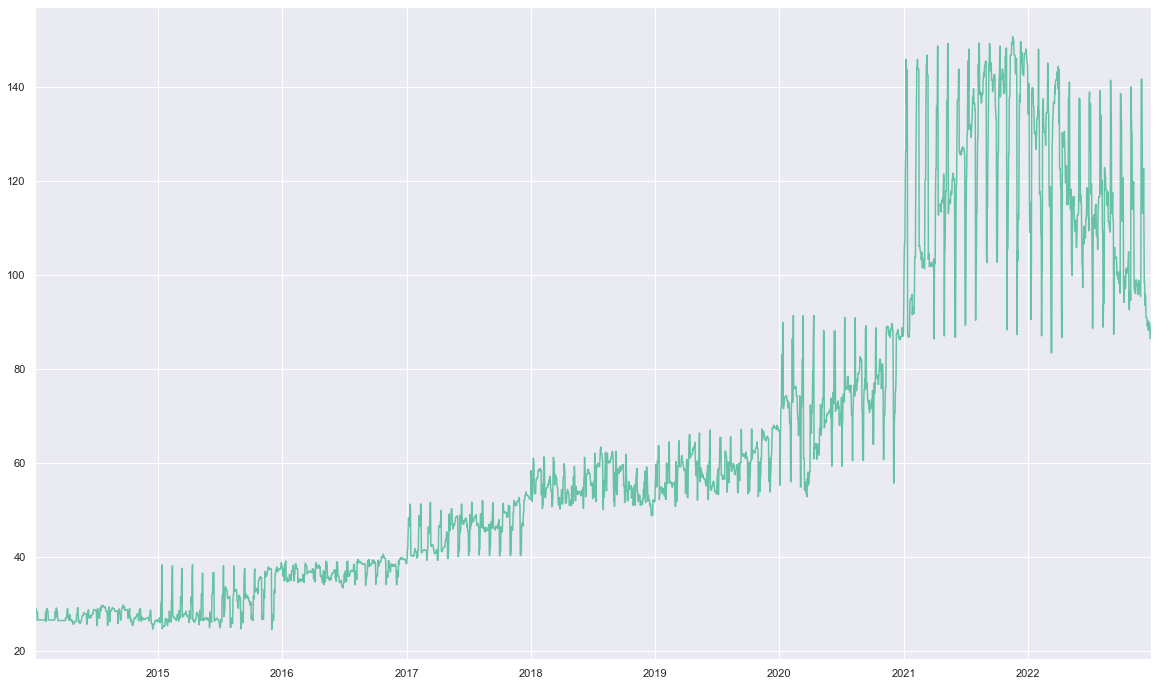

In [19]:
plot = df[ "Close"].plot(figsize=(20, 12))

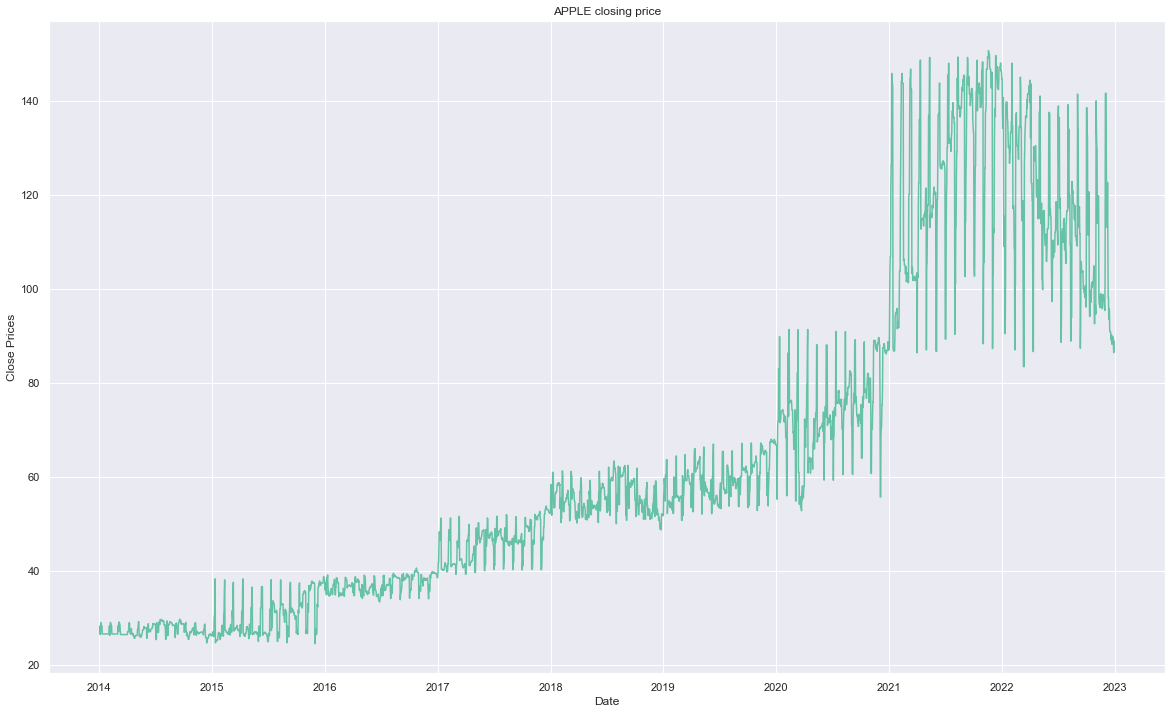

In [20]:
#plot close price
plt.figure(figsize=(20,12))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df['Close'])
plt.title('APPLE closing price')
plt.show()

In [21]:
df=df["Close"]
df

2014-01-04    28.280355
2014-01-05    26.494759
2014-01-06    26.494759
2014-01-07    29.053734
2014-01-08    28.226006
                ...    
2022-12-26    89.809998
2022-12-27    87.930000
2022-12-28    86.459999
2022-12-29    88.949997
2022-12-30    88.730003
Name: Close, Length: 3283, dtype: float64

<AxesSubplot:>

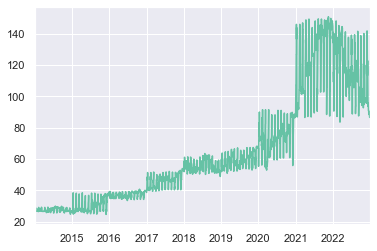

In [22]:
df.plot()

# Build model

In [23]:
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [24]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(df, WINDOW_SIZE)
X1.shape, y1.shape

((3278, 5, 1), (3278,))

# Train test split

In [25]:
X_train1, y_train1 = X1[:2922], y1[:2922]
X_test1, y_test1 = X1[2922:], y1[2922:]
X_train1.shape, y_train1.shape, X_test1.shape, y_test1.shape

((2922, 5, 1), (2922,), (356, 5, 1), (356,))

In [26]:
model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [28]:
model1.fit(X_train1, y_train1, epochs=100, callbacks=[cp1])

Epoch 1/100
87/92 [===========================>..] - ETA: 0s - loss: 4134.9795 - root_mean_squared_error: 64.3038

92/92 [==============================] - 4s 7ms/step - loss: 4116.7417 - root_mean_squared_error: 64.1618
Epoch 2/100
81/92 [=========================>....] - ETA: 0s - loss: 3990.6250 - root_mean_squared_error: 63.1714

92/92 [==============================] - 1s 6ms/step - loss: 3985.7195 - root_mean_squared_error: 63.1326
Epoch 3/100
92/92 [==============================] - ETA: 0s - loss: 3783.1975 - root_mean_squared_error: 61.5077

92/92 [==============================] - 1s 8ms/step - loss: 3783.1975 - root_mean_squared_error: 61.5077
Epoch 4/100
89/92 [============================>.] - ETA: 0s - loss: 3439.6899 - root_mean_squared_error: 58.6489

92/92 [==============================] - 1s 7ms/step - loss: 3459.7607 - root_mean_squared_error: 58.8197
Epoch 5/100
92/92 [==============================] - ETA: 0s - loss: 3051.5410 - root_mean_squared_error: 55.2408

92/92 [==============================] - 1s 7ms/step - loss: 3051.5410 - root_mean_squared_error: 55.2408
Epoch 6/100
92/92 [==============================] - ETA: 0s - loss: 2657.0964 - root_mean_squared_error: 51.5470

92/92 [==============================] - 1s 6ms/step - loss: 2657.0964 - root_mean_squared_error: 51.5470
Epoch 7/100
88/92 [===========================>..] - ETA: 0s - loss: 2381.7268 - root_mean_squared_error: 48.8029

92/92 [==============================] - 1s 7ms/step - loss: 2378.3147 - root_mean_squared_error: 48.7680
Epoch 8/100
92/92 [==============================] - ETA: 0s - loss: 2143.2056 - root_mean_squared_error: 46.2948

92/92 [==============================] - 1s 7ms/step - loss: 2143.2056 - root_mean_squared_error: 46.2948
Epoch 9/100
91/92 [============================>.] - ETA: 0s - loss: 1914.8466 - root_mean_squared_error: 43.7590

92/92 [==============================] - 1s 6ms/step - loss: 1915.6460 - root_mean_squared_error: 43.7681
Epoch 10/100
85/92 [==========================>...] - ETA: 0s - loss: 1760.5228 - root_mean_squared_error: 41.9586

92/92 [==============================] - 0s 5ms/step - loss: 1727.0042 - root_mean_squared_error: 41.5572
Epoch 11/100
84/92 [==========================>...] - ETA: 0s - loss: 1569.5072 - root_mean_squared_error: 39.6170

92/92 [==============================] - 1s 6ms/step - loss: 1583.1498 - root_mean_squared_error: 39.7888
Epoch 12/100
86/92 [===========================>..] - ETA: 0s - loss: 1469.4878 - root_mean_squared_error: 38.3339

92/92 [==============================] - 1s 6ms/step - loss: 1465.3705 - root_mean_squared_error: 38.2802
Epoch 13/100
83/92 [==========================>...] - ETA: 0s - loss: 1363.3361 - root_mean_squared_error: 36.9234

92/92 [==============================] - 1s 6ms/step - loss: 1371.3732 - root_mean_squared_error: 37.0321
Epoch 14/100
87/92 [===========================>..] - ETA: 0s - loss: 1290.2832 - root_mean_squared_error: 35.9205

92/92 [==============================] - 1s 6ms/step - loss: 1293.1389 - root_mean_squared_error: 35.9602
Epoch 15/100
86/92 [===========================>..] - ETA: 0s - loss: 1214.5457 - root_mean_squared_error: 34.8503

92/92 [==============================] - 1s 6ms/step - loss: 1222.4292 - root_mean_squared_error: 34.9633
Epoch 16/100
83/92 [==========================>...] - ETA: 0s - loss: 1153.5510 - root_mean_squared_error: 33.9640

92/92 [==============================] - 1s 6ms/step - loss: 1144.6381 - root_mean_squared_error: 33.8325
Epoch 17/100
86/92 [===========================>..] - ETA: 0s - loss: 1058.7601 - root_mean_squared_error: 32.5386

92/92 [==============================] - 1s 6ms/step - loss: 1058.6936 - root_mean_squared_error: 32.5376
Epoch 18/100
88/92 [===========================>..] - ETA: 0s - loss: 987.9415 - root_mean_squared_error: 31.4315 

92/92 [==============================] - 0s 5ms/step - loss: 986.3802 - root_mean_squared_error: 31.4067
Epoch 19/100
88/92 [===========================>..] - ETA: 0s - loss: 928.9307 - root_mean_squared_error: 30.4784

92/92 [==============================] - 1s 6ms/step - loss: 923.3968 - root_mean_squared_error: 30.3874
Epoch 20/100
89/92 [============================>.] - ETA: 0s - loss: 858.4255 - root_mean_squared_error: 29.2989

92/92 [==============================] - 1s 6ms/step - loss: 865.9604 - root_mean_squared_error: 29.4272
Epoch 21/100
88/92 [===========================>..] - ETA: 0s - loss: 822.4264 - root_mean_squared_error: 28.6780

92/92 [==============================] - 1s 6ms/step - loss: 813.9033 - root_mean_squared_error: 28.5290
Epoch 22/100
85/92 [==========================>...] - ETA: 0s - loss: 778.3243 - root_mean_squared_error: 27.8985

92/92 [==============================] - 1s 6ms/step - loss: 766.2559 - root_mean_squared_error: 27.6813
Epoch 23/100
91/92 [============================>.] - ETA: 0s - loss: 718.2516 - root_mean_squared_error: 26.8002

92/92 [==============================] - 0s 5ms/step - loss: 722.2890 - root_mean_squared_error: 26.8754
Epoch 24/100
90/92 [============================>.] - ETA: 0s - loss: 676.5289 - root_mean_squared_error: 26.0102

92/92 [==============================] - 0s 5ms/step - loss: 681.4368 - root_mean_squared_error: 26.1043
Epoch 25/100
91/92 [============================>.] - ETA: 0s - loss: 640.8091 - root_mean_squared_error: 25.3142

92/92 [==============================] - 1s 6ms/step - loss: 643.6445 - root_mean_squared_error: 25.3701
Epoch 26/100
84/92 [==========================>...] - ETA: 0s - loss: 616.0079 - root_mean_squared_error: 24.8195

92/92 [==============================] - 1s 7ms/step - loss: 607.9470 - root_mean_squared_error: 24.6566
Epoch 27/100
89/92 [============================>.] - ETA: 0s - loss: 570.7534 - root_mean_squared_error: 23.8904

92/92 [==============================] - 0s 5ms/step - loss: 574.5103 - root_mean_squared_error: 23.9689
Epoch 28/100
81/92 [=========================>....] - ETA: 0s - loss: 561.3723 - root_mean_squared_error: 23.6933

92/92 [==============================] - 0s 5ms/step - loss: 542.4665 - root_mean_squared_error: 23.2909
Epoch 29/100
87/92 [===========================>..] - ETA: 0s - loss: 519.5162 - root_mean_squared_error: 22.7929

92/92 [==============================] - 1s 6ms/step - loss: 512.0303 - root_mean_squared_error: 22.6281
Epoch 30/100
89/92 [============================>.] - ETA: 0s - loss: 479.4548 - root_mean_squared_error: 21.8965

92/92 [==============================] - 1s 7ms/step - loss: 483.1780 - root_mean_squared_error: 21.9813
Epoch 31/100
86/92 [===========================>..] - ETA: 0s - loss: 451.8777 - root_mean_squared_error: 21.2574

92/92 [==============================] - 1s 6ms/step - loss: 455.4496 - root_mean_squared_error: 21.3413
Epoch 32/100
88/92 [===========================>..] - ETA: 0s - loss: 434.2718 - root_mean_squared_error: 20.8392

92/92 [==============================] - 1s 6ms/step - loss: 429.1155 - root_mean_squared_error: 20.7151
Epoch 33/100
87/92 [===========================>..] - ETA: 0s - loss: 405.2422 - root_mean_squared_error: 20.1306

92/92 [==============================] - 1s 6ms/step - loss: 404.2294 - root_mean_squared_error: 20.1055
Epoch 34/100
85/92 [==========================>...] - ETA: 0s - loss: 385.9458 - root_mean_squared_error: 19.6455

92/92 [==============================] - 1s 7ms/step - loss: 380.4405 - root_mean_squared_error: 19.5049
Epoch 35/100
90/92 [============================>.] - ETA: 0s - loss: 351.4341 - root_mean_squared_error: 18.7466

92/92 [==============================] - 1s 6ms/step - loss: 357.5020 - root_mean_squared_error: 18.9077
Epoch 36/100
87/92 [===========================>..] - ETA: 0s - loss: 336.3238 - root_mean_squared_error: 18.3391

92/92 [==============================] - 1s 6ms/step - loss: 335.7975 - root_mean_squared_error: 18.3248
Epoch 37/100
92/92 [==============================] - ETA: 0s - loss: 314.8117 - root_mean_squared_error: 17.7429

92/92 [==============================] - 1s 6ms/step - loss: 314.8117 - root_mean_squared_error: 17.7429
Epoch 38/100
83/92 [==========================>...] - ETA: 0s - loss: 294.9727 - root_mean_squared_error: 17.1748

92/92 [==============================] - 1s 6ms/step - loss: 294.8254 - root_mean_squared_error: 17.1705
Epoch 39/100
85/92 [==========================>...] - ETA: 0s - loss: 274.0844 - root_mean_squared_error: 16.5555

92/92 [==============================] - 1s 6ms/step - loss: 275.6653 - root_mean_squared_error: 16.6032
Epoch 40/100
89/92 [============================>.] - ETA: 0s - loss: 254.6249 - root_mean_squared_error: 15.9570

92/92 [==============================] - 1s 7ms/step - loss: 257.7228 - root_mean_squared_error: 16.0537
Epoch 41/100
92/92 [==============================] - ETA: 0s - loss: 240.7044 - root_mean_squared_error: 15.5147

92/92 [==============================] - 0s 5ms/step - loss: 240.7044 - root_mean_squared_error: 15.5147
Epoch 42/100
84/92 [==========================>...] - ETA: 0s - loss: 235.0105 - root_mean_squared_error: 15.3301

92/92 [==============================] - 1s 6ms/step - loss: 224.4650 - root_mean_squared_error: 14.9822
Epoch 43/100
87/92 [===========================>..] - ETA: 0s - loss: 211.9952 - root_mean_squared_error: 14.5601

92/92 [==============================] - 1s 6ms/step - loss: 209.0136 - root_mean_squared_error: 14.4573
Epoch 44/100
90/92 [============================>.] - ETA: 0s - loss: 193.2307 - root_mean_squared_error: 13.9007

92/92 [==============================] - 1s 6ms/step - loss: 194.2444 - root_mean_squared_error: 13.9372
Epoch 45/100
91/92 [============================>.] - ETA: 0s - loss: 180.8674 - root_mean_squared_error: 13.4487

92/92 [==============================] - 1s 7ms/step - loss: 180.3107 - root_mean_squared_error: 13.4280
Epoch 46/100
84/92 [==========================>...] - ETA: 0s - loss: 172.0788 - root_mean_squared_error: 13.1179

92/92 [==============================] - 1s 6ms/step - loss: 167.2160 - root_mean_squared_error: 12.9312
Epoch 47/100
89/92 [============================>.] - ETA: 0s - loss: 154.2464 - root_mean_squared_error: 12.4196

92/92 [==============================] - 0s 5ms/step - loss: 154.6423 - root_mean_squared_error: 12.4355
Epoch 48/100
89/92 [============================>.] - ETA: 0s - loss: 142.0854 - root_mean_squared_error: 11.9200

92/92 [==============================] - 0s 5ms/step - loss: 142.9522 - root_mean_squared_error: 11.9563
Epoch 49/100
85/92 [==========================>...] - ETA: 0s - loss: 127.4197 - root_mean_squared_error: 11.2880

92/92 [==============================] - 1s 6ms/step - loss: 131.7254 - root_mean_squared_error: 11.4772
Epoch 50/100
92/92 [==============================] - ETA: 0s - loss: 121.4819 - root_mean_squared_error: 11.0219

92/92 [==============================] - 0s 5ms/step - loss: 121.4819 - root_mean_squared_error: 11.0219
Epoch 51/100
83/92 [==========================>...] - ETA: 0s - loss: 111.5363 - root_mean_squared_error: 10.5611

92/92 [==============================] - 1s 6ms/step - loss: 112.1090 - root_mean_squared_error: 10.5882
Epoch 52/100
90/92 [============================>.] - ETA: 0s - loss: 102.8231 - root_mean_squared_error: 10.1402

92/92 [==============================] - 1s 5ms/step - loss: 103.3596 - root_mean_squared_error: 10.1666
Epoch 53/100
85/92 [==========================>...] - ETA: 0s - loss: 95.7295 - root_mean_squared_error: 9.7841

92/92 [==============================] - 1s 6ms/step - loss: 95.2682 - root_mean_squared_error: 9.7605
Epoch 54/100
86/92 [===========================>..] - ETA: 0s - loss: 88.0572 - root_mean_squared_error: 9.3839

92/92 [==============================] - 1s 7ms/step - loss: 87.7954 - root_mean_squared_error: 9.3699
Epoch 55/100
88/92 [===========================>..] - ETA: 0s - loss: 80.7035 - root_mean_squared_error: 8.9835

92/92 [==============================] - 1s 7ms/step - loss: 80.8099 - root_mean_squared_error: 8.9894
Epoch 56/100
91/92 [============================>.] - ETA: 0s - loss: 74.4673 - root_mean_squared_error: 8.6294

92/92 [==============================] - 1s 8ms/step - loss: 74.5179 - root_mean_squared_error: 8.6324
Epoch 57/100
92/92 [==============================] - ETA: 0s - loss: 68.6732 - root_mean_squared_error: 8.2869

92/92 [==============================] - 1s 8ms/step - loss: 68.6732 - root_mean_squared_error: 8.2869
Epoch 58/100
89/92 [============================>.] - ETA: 0s - loss: 63.5268 - root_mean_squared_error: 7.9704

92/92 [==============================] - 1s 7ms/step - loss: 63.4088 - root_mean_squared_error: 7.9630
Epoch 59/100
87/92 [===========================>..] - ETA: 0s - loss: 58.4229 - root_mean_squared_error: 7.6435

92/92 [==============================] - 1s 8ms/step - loss: 58.5517 - root_mean_squared_error: 7.6519
Epoch 60/100
87/92 [===========================>..] - ETA: 0s - loss: 52.7767 - root_mean_squared_error: 7.2648

92/92 [==============================] - 1s 7ms/step - loss: 54.1114 - root_mean_squared_error: 7.3560
Epoch 61/100
88/92 [===========================>..] - ETA: 0s - loss: 51.2548 - root_mean_squared_error: 7.1592

92/92 [==============================] - 1s 7ms/step - loss: 50.1137 - root_mean_squared_error: 7.0791
Epoch 62/100
92/92 [==============================] - ETA: 0s - loss: 46.5131 - root_mean_squared_error: 6.8200

92/92 [==============================] - 1s 8ms/step - loss: 46.5131 - root_mean_squared_error: 6.8200
Epoch 63/100
88/92 [===========================>..] - ETA: 0s - loss: 43.9209 - root_mean_squared_error: 6.6273

92/92 [==============================] - 1s 7ms/step - loss: 43.3156 - root_mean_squared_error: 6.5815
Epoch 64/100
90/92 [============================>.] - ETA: 0s - loss: 40.7961 - root_mean_squared_error: 6.3872

92/92 [==============================] - 1s 7ms/step - loss: 40.3549 - root_mean_squared_error: 6.3525
Epoch 65/100
89/92 [============================>.] - ETA: 0s - loss: 37.3651 - root_mean_squared_error: 6.1127

92/92 [==============================] - 1s 8ms/step - loss: 37.6812 - root_mean_squared_error: 6.1385
Epoch 66/100
89/92 [============================>.] - ETA: 0s - loss: 35.2815 - root_mean_squared_error: 5.9398

92/92 [==============================] - 1s 8ms/step - loss: 35.2994 - root_mean_squared_error: 5.9413
Epoch 67/100
90/92 [============================>.] - ETA: 0s - loss: 32.9830 - root_mean_squared_error: 5.7431

92/92 [==============================] - 1s 8ms/step - loss: 33.1506 - root_mean_squared_error: 5.7577
Epoch 68/100
86/92 [===========================>..] - ETA: 0s - loss: 32.7001 - root_mean_squared_error: 5.7184

92/92 [==============================] - 1s 8ms/step - loss: 31.2935 - root_mean_squared_error: 5.5941
Epoch 69/100
87/92 [===========================>..] - ETA: 0s - loss: 29.2723 - root_mean_squared_error: 5.4104

92/92 [==============================] - 1s 7ms/step - loss: 29.4792 - root_mean_squared_error: 5.4295
Epoch 70/100
92/92 [==============================] - ETA: 0s - loss: 27.9772 - root_mean_squared_error: 5.2894

92/92 [==============================] - 1s 8ms/step - loss: 27.9772 - root_mean_squared_error: 5.2894
Epoch 71/100
91/92 [============================>.] - ETA: 0s - loss: 26.7260 - root_mean_squared_error: 5.1697

92/92 [==============================] - 1s 8ms/step - loss: 26.6610 - root_mean_squared_error: 5.1634
Epoch 72/100
92/92 [==============================] - ETA: 0s - loss: 25.4578 - root_mean_squared_error: 5.0456

92/92 [==============================] - 1s 8ms/step - loss: 25.4578 - root_mean_squared_error: 5.0456
Epoch 73/100
87/92 [===========================>..] - ETA: 0s - loss: 24.2217 - root_mean_squared_error: 4.9216

92/92 [==============================] - 1s 7ms/step - loss: 24.5588 - root_mean_squared_error: 4.9557
Epoch 74/100
91/92 [============================>.] - ETA: 0s - loss: 23.6198 - root_mean_squared_error: 4.8600

92/92 [==============================] - 1s 8ms/step - loss: 23.5565 - root_mean_squared_error: 4.8535
Epoch 75/100
89/92 [============================>.] - ETA: 0s - loss: 22.7667 - root_mean_squared_error: 4.7714

92/92 [==============================] - 1s 8ms/step - loss: 22.8221 - root_mean_squared_error: 4.7773
Epoch 76/100
90/92 [============================>.] - ETA: 0s - loss: 22.0124 - root_mean_squared_error: 4.6917

92/92 [==============================] - 1s 8ms/step - loss: 22.0771 - root_mean_squared_error: 4.6986
Epoch 77/100
88/92 [===========================>..] - ETA: 0s - loss: 21.7224 - root_mean_squared_error: 4.6607

92/92 [==============================] - 1s 8ms/step - loss: 21.5537 - root_mean_squared_error: 4.6426
Epoch 78/100
85/92 [==========================>...] - ETA: 0s - loss: 20.3953 - root_mean_squared_error: 4.5161

92/92 [==============================] - 1s 8ms/step - loss: 21.1087 - root_mean_squared_error: 4.5944
Epoch 79/100
84/92 [==========================>...] - ETA: 0s - loss: 20.3177 - root_mean_squared_error: 4.5075

92/92 [==============================] - 1s 8ms/step - loss: 20.5200 - root_mean_squared_error: 4.5299
Epoch 80/100
87/92 [===========================>..] - ETA: 0s - loss: 20.5992 - root_mean_squared_error: 4.5386

92/92 [==============================] - 1s 8ms/step - loss: 20.1636 - root_mean_squared_error: 4.4904
Epoch 81/100
89/92 [============================>.] - ETA: 0s - loss: 19.7008 - root_mean_squared_error: 4.4386

92/92 [==============================] - 1s 8ms/step - loss: 19.8835 - root_mean_squared_error: 4.4591
Epoch 82/100
87/92 [===========================>..] - ETA: 0s - loss: 20.2269 - root_mean_squared_error: 4.4974

92/92 [==============================] - 1s 8ms/step - loss: 19.6382 - root_mean_squared_error: 4.4315
Epoch 83/100
89/92 [============================>.] - ETA: 0s - loss: 19.7151 - root_mean_squared_error: 4.4402

92/92 [==============================] - 1s 8ms/step - loss: 19.3494 - root_mean_squared_error: 4.3988
Epoch 84/100
89/92 [============================>.] - ETA: 0s - loss: 18.9306 - root_mean_squared_error: 4.3509

92/92 [==============================] - 1s 8ms/step - loss: 19.0132 - root_mean_squared_error: 4.3604
Epoch 85/100
87/92 [===========================>..] - ETA: 0s - loss: 17.8741 - root_mean_squared_error: 4.2278

92/92 [==============================] - 1s 9ms/step - loss: 19.0359 - root_mean_squared_error: 4.3630
Epoch 86/100
90/92 [============================>.] - ETA: 0s - loss: 18.8641 - root_mean_squared_error: 4.3433

92/92 [==============================] - 1s 6ms/step - loss: 18.7959 - root_mean_squared_error: 4.3354
Epoch 87/100
84/92 [==========================>...] - ETA: 0s - loss: 18.6763 - root_mean_squared_error: 4.3216

92/92 [==============================] - 1s 6ms/step - loss: 18.6801 - root_mean_squared_error: 4.3221
Epoch 88/100
86/92 [===========================>..] - ETA: 0s - loss: 17.7296 - root_mean_squared_error: 4.2107

92/92 [==============================] - 1s 6ms/step - loss: 18.5526 - root_mean_squared_error: 4.3073
Epoch 89/100
90/92 [============================>.] - ETA: 0s - loss: 18.5650 - root_mean_squared_error: 4.3087

92/92 [==============================] - 1s 9ms/step - loss: 18.4206 - root_mean_squared_error: 4.2919
Epoch 90/100
88/92 [===========================>..] - ETA: 0s - loss: 18.7915 - root_mean_squared_error: 4.3349

92/92 [==============================] - 1s 9ms/step - loss: 18.5061 - root_mean_squared_error: 4.3019
Epoch 91/100
88/92 [===========================>..] - ETA: 0s - loss: 18.6642 - root_mean_squared_error: 4.3202

92/92 [==============================] - 1s 9ms/step - loss: 18.2557 - root_mean_squared_error: 4.2727
Epoch 92/100
86/92 [===========================>..] - ETA: 0s - loss: 18.8381 - root_mean_squared_error: 4.3403

92/92 [==============================] - 1s 7ms/step - loss: 18.2053 - root_mean_squared_error: 4.2668
Epoch 93/100
88/92 [===========================>..] - ETA: 0s - loss: 18.3698 - root_mean_squared_error: 4.2860

92/92 [==============================] - 1s 7ms/step - loss: 18.1687 - root_mean_squared_error: 4.2625
Epoch 94/100
87/92 [===========================>..] - ETA: 0s - loss: 17.0306 - root_mean_squared_error: 4.1268

92/92 [==============================] - 1s 8ms/step - loss: 18.0859 - root_mean_squared_error: 4.2528
Epoch 95/100
82/92 [=========================>....] - ETA: 0s - loss: 17.7811 - root_mean_squared_error: 4.2168

92/92 [==============================] - 1s 8ms/step - loss: 18.0548 - root_mean_squared_error: 4.2491
Epoch 96/100
92/92 [==============================] - ETA: 0s - loss: 17.9846 - root_mean_squared_error: 4.2408

92/92 [==============================] - 1s 8ms/step - loss: 17.9846 - root_mean_squared_error: 4.2408
Epoch 97/100
87/92 [===========================>..] - ETA: 0s - loss: 18.2912 - root_mean_squared_error: 4.2768

92/92 [==============================] - 1s 8ms/step - loss: 18.1291 - root_mean_squared_error: 4.2578
Epoch 98/100
89/92 [============================>.] - ETA: 0s - loss: 17.7474 - root_mean_squared_error: 4.2128

92/92 [==============================] - 1s 7ms/step - loss: 18.0443 - root_mean_squared_error: 4.2479
Epoch 99/100
90/92 [============================>.] - ETA: 0s - loss: 17.4557 - root_mean_squared_error: 4.1780

92/92 [==============================] - 1s 7ms/step - loss: 17.8720 - root_mean_squared_error: 4.2275
Epoch 100/100
91/92 [============================>.] - ETA: 0s - loss: 17.9144 - root_mean_squared_error: 4.2325

92/92 [==============================] - 1s 7ms/step - loss: 17.8748 - root_mean_squared_error: 4.2279


In [29]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

92/92 [==============================] - 1s 3ms/step


,Train Predictions,Actuals
0,28.198471,28.226006
1,28.329924,28.335705
2,28.395060,28.335705
3,28.382683,26.616922
4,26.982000,26.616922
...,...,...
2917,136.384628,140.699997
2918,138.426743,140.699997
2919,139.015472,114.137001
2920,116.720261,109.081001


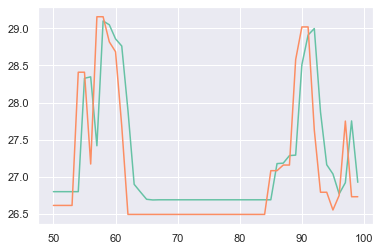

In [30]:

plt.plot(train_results['Train Predictions'][50:100])
plt.plot(train_results['Actuals'][50:100])

In [31]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

12/12 [==============================] - 0s 3ms/step


,Test Predictions,Actuals
0,117.094276,110.550003
1,112.385788,110.550003
2,111.866379,90.500000
3,95.110878,101.279999
4,102.899780,139.130997
...,...,...
351,88.847229,89.809998
352,88.913338,87.930000
353,87.240395,86.459999
354,85.879478,88.949997


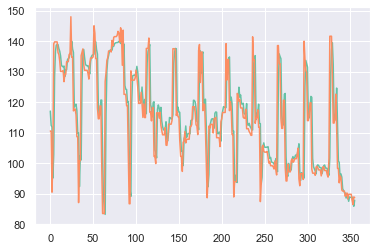

In [32]:
plt.plot(test_results['Test Predictions'][:356])
plt.plot(test_results['Actuals'][:356])

# Evaluating forecast results

In [33]:
score = np.sqrt(mean_squared_error(test_results['Test Predictions'], test_results['Actuals']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 9.23


In [34]:
# report performance
mse = mean_squared_error(test_predictions, y_test1)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_predictions, y_test1)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_predictions, y_test1))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(y_test1 - test_predictions)/np.abs(test_predictions))
print('MAPE: '+str(mape))

MSE: 85.10195356024187
MAE: 5.220413007775468
RMSE: 9.225072008404155
MAPE: 0.04616280969440036


In [35]:
get_mda(y_test1,test_predictions)

0.3464788732394366

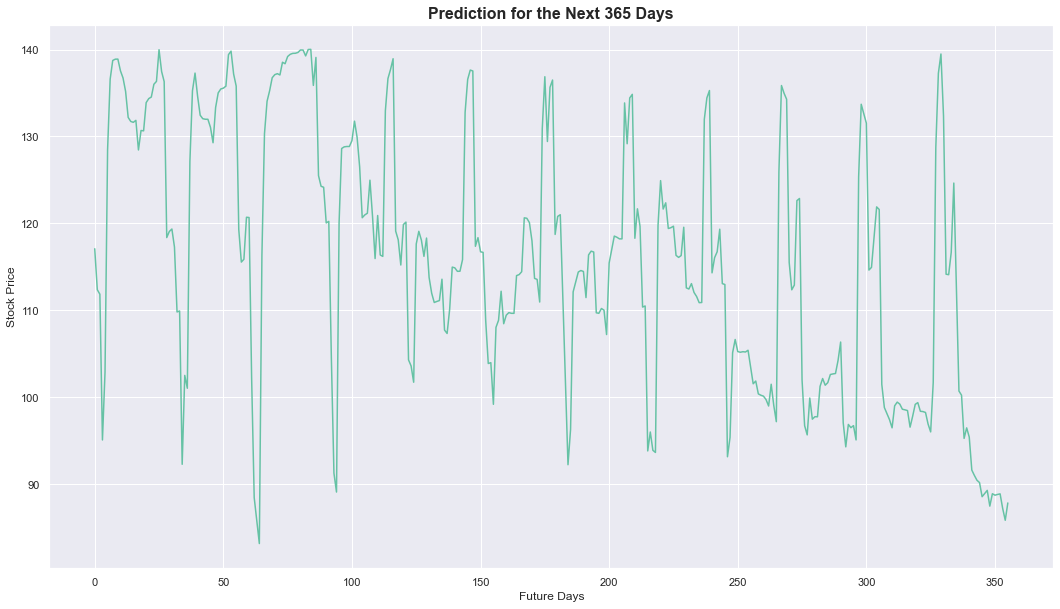

In [41]:
plt.figure(figsize=(18,10))
plt.plot(test_results['Test Predictions'][:356])
plt.title("Prediction for the Next 365 Days",fontsize=16, fontweight='bold')
plt.xlabel("Future Days")
plt.ylabel("Stock Price")
plt.show()
